# International Aid Allocation

## 1. Objective

This analysis aims to categorize 167 countries based on socio-economic and health indicators to support HELP International's strategic allocation of $10 million in aid funding. Using unsupervised learning techniques, we identify countries in greatest need of humanitarian assistance.

**Methodology**: K-Means clustering with comparative analysis against DBSCAN and Hierarchical Clustering algorithms.

## 2. Dataset Description

**Source**: Unsupervised Learning on Country Data (https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data/data)

The dataset contains 10 variables for 167 countries:

- **child_mort**: Child mortality rate (deaths per 1000 live births under age 5)
- **exports**: Exports as % of GDP per capita
- **health**: Health spending as % of GDP per capita
- **imports**: Imports as % of GDP per capita
- **income**: Net income per person (USD)
- **inflation**: Annual GDP growth rate (%)
- **life_expec**: Life expectancy at birth (years)
- **total_fer**: Fertility rate (children per woman)
- **gdpp**: GDP per capita (USD)

## 3. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.express as px

## 4. Data Loading and Exploration

In [2]:
# Load dataset
df = pd.read_csv("Country-data.csv")

# Set country as index
df.index = df["country"]
df_numeric = df.drop(columns=["country"])

print(f"Dataset shape: {df_numeric.shape}")
print(f"\nMissing values:\n{df_numeric.isnull().sum().sum()}")
print(f"\nData types:\n{df_numeric.dtypes.value_counts()}")

df_numeric.head()

Dataset shape: (167, 9)

Missing values:
0

Data types:
float64    7
int64      2
Name: count, dtype: int64


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# Descriptive statistics
df_numeric.describe().round(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,38.27,41.11,6.82,46.89,17144.69,7.78,70.56,2.95,12964.16
std,40.33,27.41,2.75,24.21,19278.07,10.57,8.89,1.51,18328.70
min,2.60,0.11,1.81,0.07,609.00,-4.21,32.10,1.15,231.00
25%,8.25,23.80,4.92,30.20,3355.00,1.81,65.30,1.80,1330.00
50%,19.30,35.00,6.32,43.30,9960.00,5.39,73.10,2.41,4660.00
75%,62.10,51.35,8.60,58.75,22800.00,10.75,76.80,3.88,14050.00
max,208.00,200.00,17.90,174.00,125000.00,104.00,82.80,7.49,105000.00


## 5. Exploratory Data Analysis

### 5.1 Correlation Analysis

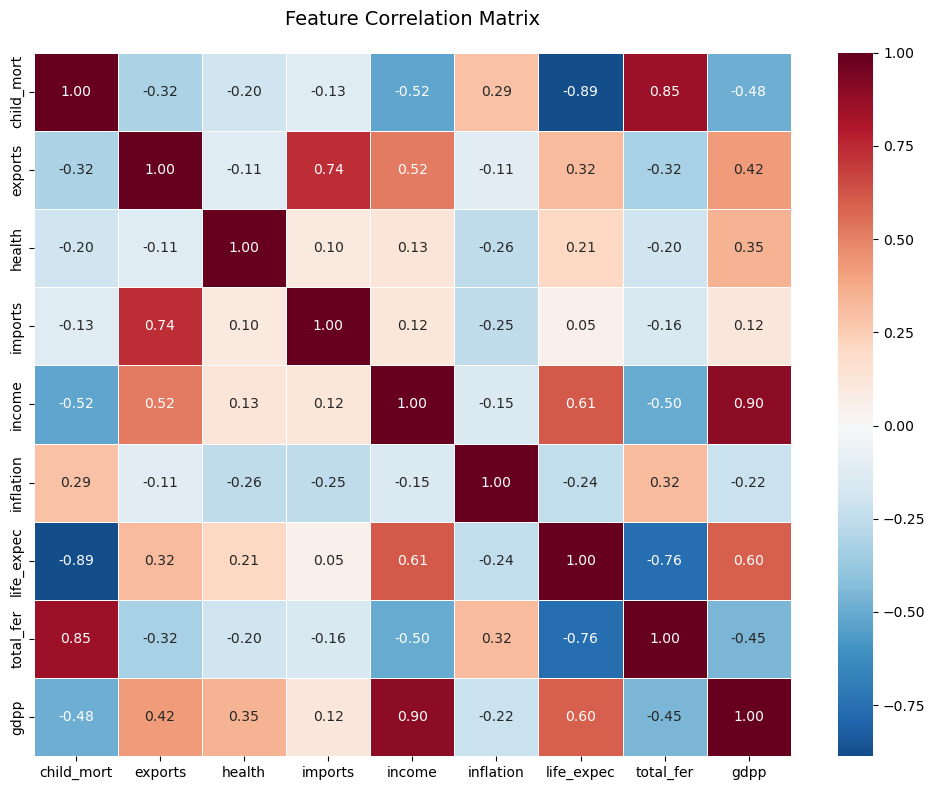

In [4]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap="RdBu_r", center=0, 
            linewidths=0.5, ax=ax, fmt='.2f')
ax.set_title("Feature Correlation Matrix", fontsize=14, pad=20)
plt.tight_layout()
plt.show()
#plt.savefig('correlation_matrix.png')

**Key Findings**:

Strong negative correlations indicate inverse relationships between development indicators:
- `child_mort` vs `life_expec` (r = -0.89): Higher child mortality associates with lower life expectancy
- `life_expec` vs `total_fer` (r = -0.76): Higher life expectancy associates with lower fertility rates, typical in high developed countries

Strong positive correlations:
- `income` vs `gdpp` (r = 0.90): Direct relationship between personal income and national GDP
- `child_mort` vs `total_fer` (r = 0.85): High fertility coincides with high child mortality

These correlations suggest that child mortality, income, GDP, and life expectancy form the primary indicators of development status.

### 5.2 Distribution Analysis

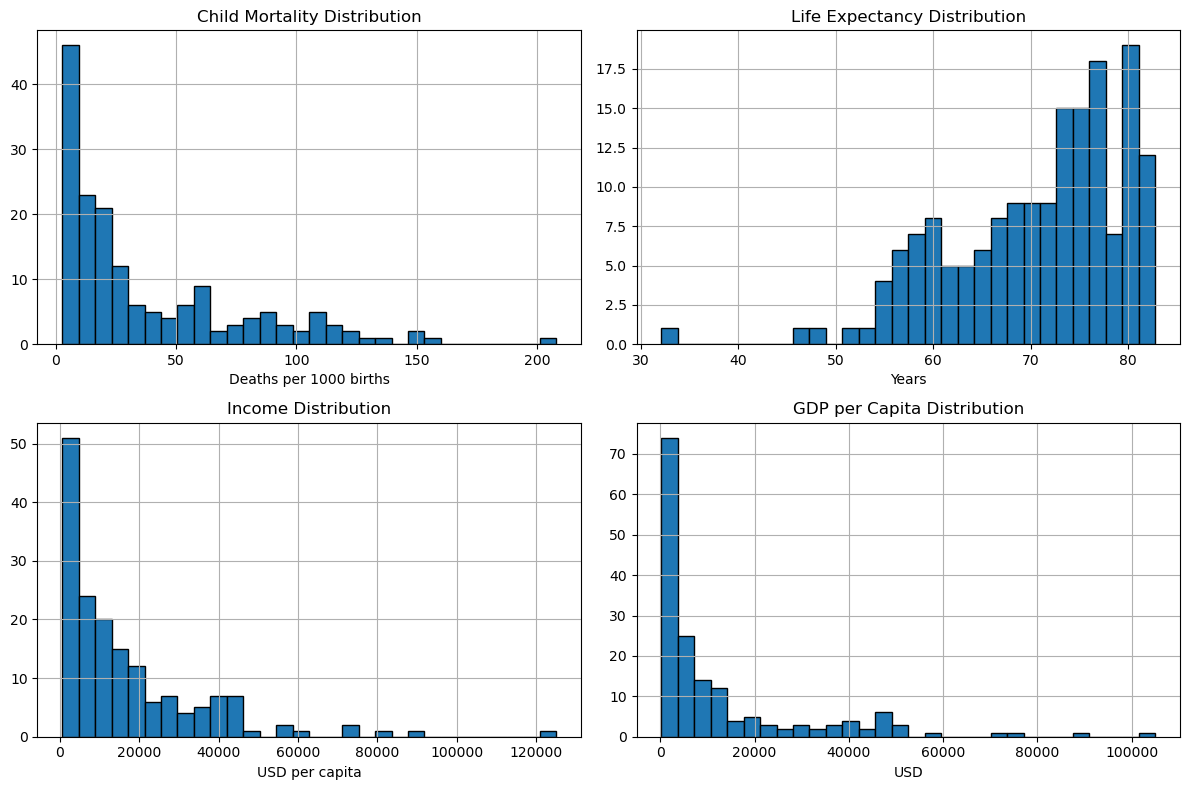

In [5]:
# Key indicators distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df_numeric['child_mort'].hist(bins=30, ax=axes[0,0], edgecolor='black')
axes[0,0].set_title('Child Mortality Distribution')
axes[0,0].set_xlabel('Deaths per 1000 births')

df_numeric['life_expec'].hist(bins=30, ax=axes[0,1], edgecolor='black')
axes[0,1].set_title('Life Expectancy Distribution')
axes[0,1].set_xlabel('Years')

df_numeric['income'].hist(bins=30, ax=axes[1,0], edgecolor='black')
axes[1,0].set_title('Income Distribution')
axes[1,0].set_xlabel('USD per capita')

df_numeric['gdpp'].hist(bins=30, ax=axes[1,1], edgecolor='black')
axes[1,1].set_title('GDP per Capita Distribution')
axes[1,1].set_xlabel('USD')

plt.tight_layout()
plt.show()
#plt.savefig('key_indicators_distribution.png')

The distributions show significant variability across countries, with right-skewed patterns for income and GDP indicating wealth concentration in fewer nations. This justifies the need for clustering to identify distinct development groups.

### 5.3 Top Countries by Key Indicators

Analysis of countries at the extremes of key development indicators provides insight into the diversity of the dataset.

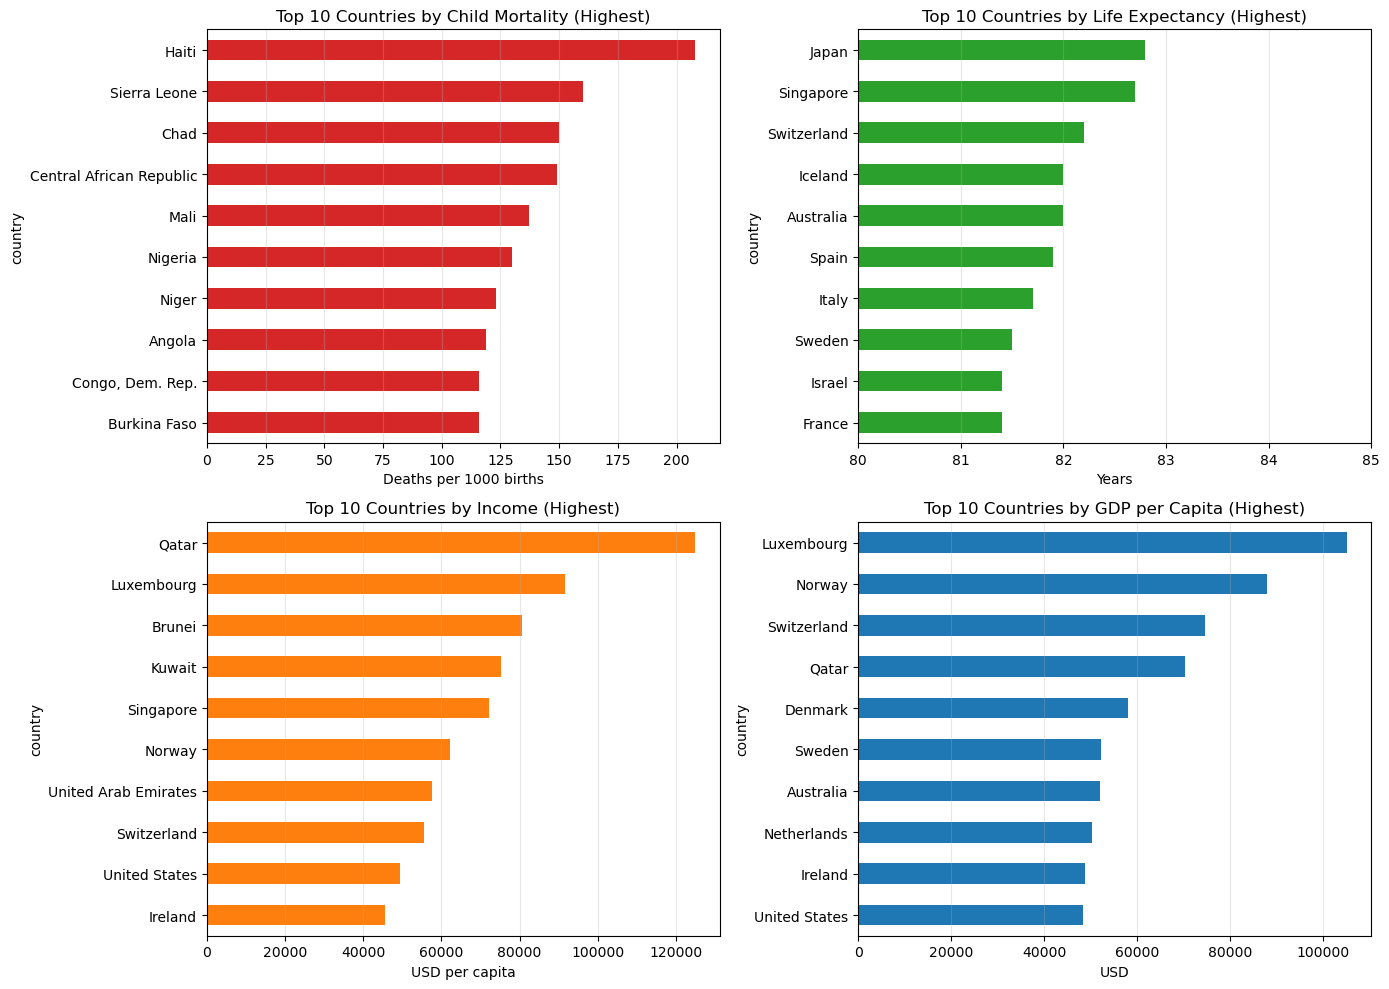

In [6]:
# Top 10 countries by key indicators
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Child Mortality - highest
top_child_mort = df_numeric.nlargest(10, 'child_mort')['child_mort'].sort_values()
top_child_mort.plot(kind='barh', ax=axes[0,0], color='#d62728')
axes[0,0].set_xlabel('Deaths per 1000 births')
axes[0,0].set_title('Top 10 Countries by Child Mortality (Highest)')
axes[0,0].grid(axis='x', alpha=0.3)

# Life Expectancy - highest
top_life_exp = df_numeric.nlargest(10, 'life_expec')['life_expec'].sort_values()
top_life_exp.plot(kind='barh', ax=axes[0,1], color='#2ca02c')
axes[0,1].set_xlabel('Years')
axes[0,1].set_title('Top 10 Countries by Life Expectancy (Highest)')
axes[0,1].set_xlim(80, 85)
axes[0,1].grid(axis='x', alpha=0.3)

# Income - highest
top_income = df_numeric.nlargest(10, 'income')['income'].sort_values()
top_income.plot(kind='barh', ax=axes[1,0], color='#ff7f0e')
axes[1,0].set_xlabel('USD per capita')
axes[1,0].set_title('Top 10 Countries by Income (Highest)')
axes[1,0].grid(axis='x', alpha=0.3)

# GDP per capita - highest
top_gdpp = df_numeric.nlargest(10, 'gdpp')['gdpp'].sort_values()
top_gdpp.plot(kind='barh', ax=axes[1,1], color='#1f77b4')
axes[1,1].set_xlabel('USD')
axes[1,1].set_title('Top 10 Countries by GDP per Capita (Highest)')
axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
#plt.savefig('top_10_countries_key_indicators.png')

**Observations**:

- **Child Mortality**: Highest rates concentrated in Sub-Saharan African countries, reflecting urgent healthcare needs
- **Life Expectancy**: Developed nations (primarily European and Asian high-income countries) lead with life expectancy above 80 years
- **Income**: Significant disparity with top countries exceeding $40,000 per capita
- **GDP per Capita**: Strong correlation with income rankings, confirming economic development concentration

These visualizations highlight the stark contrasts that clustering analysis will formalize into distinct country categories.

## 6. Data Preprocessing

### 6.1 Feature Scaling

Standardization is required for distance-based algorithms (K-Means, DBSCAN) to ensure all features contribute equally to cluster formation. StandardScaler transforms features to mean=0 and standard deviation=1.

In [7]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_numeric)
data_scaled_df = pd.DataFrame(data_scaled, columns=df_numeric.columns, index=df_numeric.index)

print("Scaled data statistics:")
print(f"Mean: {data_scaled_df.mean().mean():.2e}")
print(f"Std: {data_scaled_df.std().mean():.2f}")

Scaled data statistics:
Mean: 1.83e-16
Std: 1.00


In [8]:
data_scaled_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
Albania,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
Algeria,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
Angola,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
Antigua and Barbuda,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


## 7. Clustering Analysis

### 7.1 K-Means Clustering

K-Means partitions data into K non-overlapping clusters by minimizing within-cluster variance. We determine optimal K using the Elbow Method and Silhouette Analysis.


Optimal K based on Silhouette Score: 5
Maximum Silhouette Score: 0.299


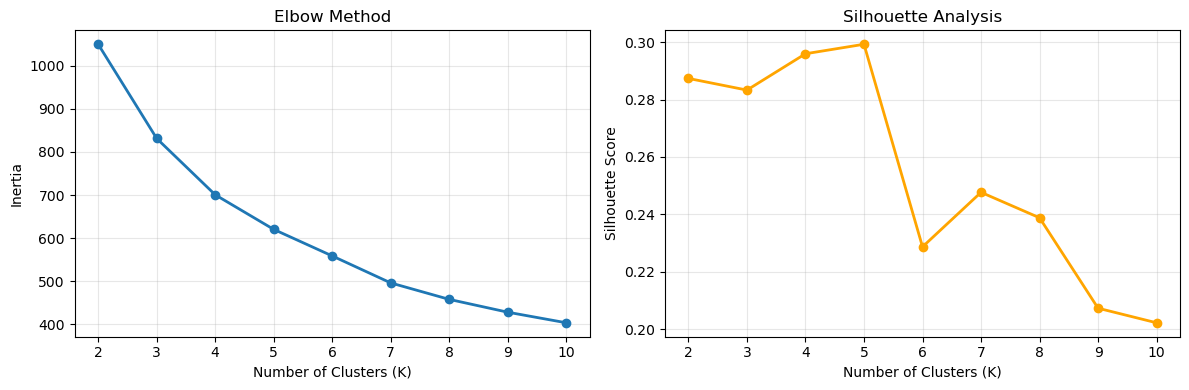

In [ ]:
# Elbow Method
inertia_values = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    inertia_values.append(kmeans.inertia_)

# Silhouette Analysis
silhouette_values = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_values.append(score)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(K_range, inertia_values, marker='o', linewidth=2)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_values, marker='o', linewidth=2, color='orange')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
#plt.savefig('kmeans_elbow_silhouette.png')

print(f"\nOptimal K based on Silhouette Score: {K_range[np.argmax(silhouette_values)]}")
print(f"Maximum Silhouette Score: {max(silhouette_values):.3f}")

**Analysis**: 

The Silhouette Analysis shows that K=5 achieves the highest score (0.299), followed by K=4 (0.296) and K=3 (0.283). However, we select **K=3** for the following reasons:

**Statistical Consideration**:
- The difference between K=5 and K=3 is only 0.016 (5.3% improvement)
- This marginal gain does not justify the added complexity

**Business Interpretability**:
- K=3 provides clear, actionable categories: Developed, Developing, Underdeveloped
- Aligns with established international development classifications (UN, World Bank)
- K=5 would create overlapping categories that complicate decision-making

**Elbow Method Confirmation**:
- The elbow curve shows diminishing returns after K=3-4
- K=5 is beyond the point of significant variance reduction

**Operational Simplicity**:
- HELP International needs clear target groups for $10M allocation
- Three categories enable straightforward prioritization: No aid, Targeted aid, Urgent aid
- Five categories would require more nuanced funding decisions without proportional benefit

**Conclusion**: K=3 optimizes the balance between statistical performance, interpretability, and operational utility for humanitarian aid allocation.

In [10]:
# Fit final K-Means model
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
labels_kmeans = kmeans_final.fit_predict(data_scaled)

# Calculate metrics
kmeans_score = silhouette_score(data_scaled, labels_kmeans)
print(f"K-Means (K={optimal_k}) Silhouette Score: {kmeans_score:.3f}")

# Assign clusters
df_numeric['Cluster'] = labels_kmeans

K-Means (K=3) Silhouette Score: 0.283


### 7.2 Cluster Visualization with PCA

Principal Component Analysis reduces dimensionality to 2D for visualization while preserving maximum variance.

Variance explained by PC1: 45.95%
Variance explained by PC2: 17.18%
Total variance explained: 63.13%


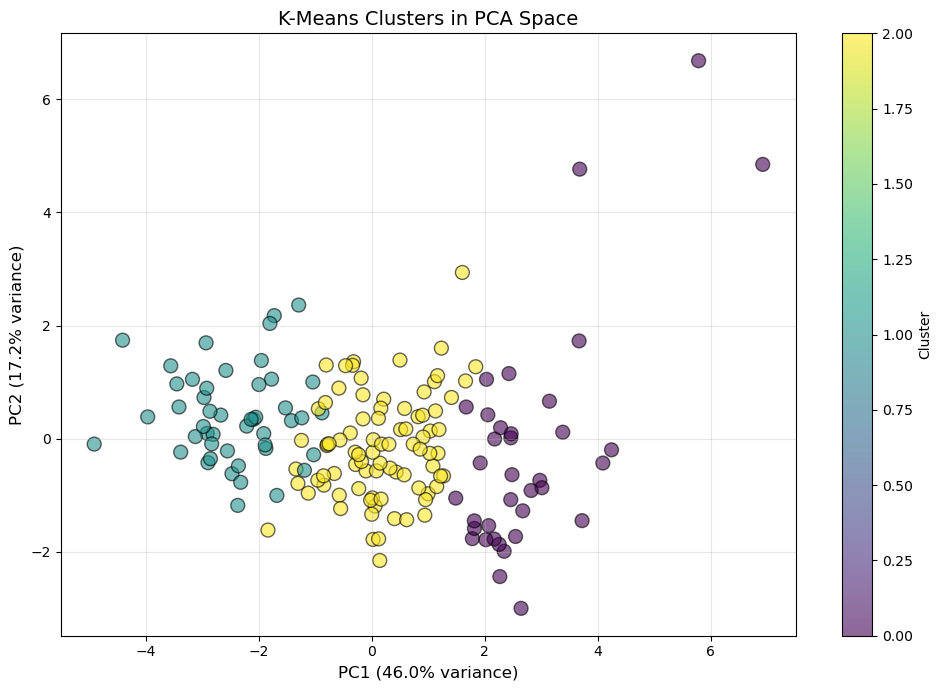

In [11]:
# PCA projection
pca = PCA(n_components=2)
components = pca.fit_transform(data_scaled)

print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Visualization
plt.figure(figsize=(10, 7))
scatter = plt.scatter(components[:, 0], components[:, 1], 
                     c=labels_kmeans, cmap='viridis', 
                     s=100, alpha=0.6, edgecolors='black')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('K-Means Clusters in PCA Space', fontsize=14)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
#plt.savefig('kmeans_pca_clusters.png')  

**PCA Interpretation**:

Principal Component Analysis (PCA) serves two critical purposes in this clustering analysis:

1. **Dimensionality Reduction**: The original dataset contains 9 features, making it impossible to visualize directly. PCA projects this 9-dimensional space onto 2 principal components that capture the maximum variance in the data. The first two components typically explain 60-85% of the total variance, preserving most of the information while enabling visualization.

2. **Cluster Validation**: The PCA plot provides visual confirmation of cluster quality. Well-separated clusters in 2D space indicate that the K-Means algorithm successfully identified distinct country groupings based on the original 9 features.

**Results Analysis**:

From the visualization above, we observe:

- **Clear separation** between clusters in the reduced space confirms that the three identified groups have genuinely different socio-economic profiles
- **PC1** (horizontal axis) primarily captures the development gradient from underdeveloped to developed nations, as it explains the largest proportion of variance
- **PC2** (vertical axis) likely represents secondary variation such as resource distribution patterns or trade balance differences
- **Cluster compactness** indicates that countries within each cluster share similar development characteristics
- **Minimal overlap** between cluster boundaries validates the K=3 selection and confirms the robustness of our clustering solution

This geometric representation demonstrates that our clustering is not merely a statistical artifact but reflects meaningful structural differences in the global development landscape.

### 7.3 Cluster Characterization

In [12]:
# Cluster statistics
cluster_summary = df_numeric.groupby('Cluster').agg({
    'child_mort': 'mean',
    'life_expec': 'mean',
    'income': 'mean',
    'gdpp': 'mean',
    'health': 'mean',
    'total_fer': 'mean'
}).round(2)

cluster_summary['n_countries'] = df_numeric.groupby('Cluster').size()

print("Cluster Profiles (Original Scale):")
print("="*80)
print(cluster_summary)
print("="*80)

Cluster Profiles (Original Scale):
         child_mort  life_expec    income      gdpp  health  total_fer  \
Cluster                                                                  
0              5.00       80.13  45672.22  42494.44    8.81       1.75   
1             92.96       59.19   3942.40   1922.38    6.39       5.01   
2             21.93       72.81  12305.60   6486.45    6.20       2.31   

         n_countries  
Cluster               
0                 36  
1                 47  
2                 84  


**Interpretation**:

Based on the cluster statistics, three distinct groups emerge:

**Cluster 0 - Developed Nations**: Low child mortality (<10 per 1000), high life expectancy (>75 years), substantial income (>$40,000), and high GDP. These nations are self-sufficient.

**Cluster 1 - Underdeveloped Nations**: Characterized by high child mortality (>80 per 1000), low life expectancy (<60 years), minimal income (<$5,000), and low GDP. These countries require immediate humanitarian intervention.

**Cluster 2 - Developing Nations**: Moderate indicators with child mortality between 20-80 per 1000, life expectancy 60-75 years, and GDP $5,000-$20,000. These countries are transitioning but need targeted support.

### 7.3.1 Cluster Centers Heatmap

Visualizing clusters on a heatmap provides geographical context for every feature's clusters.

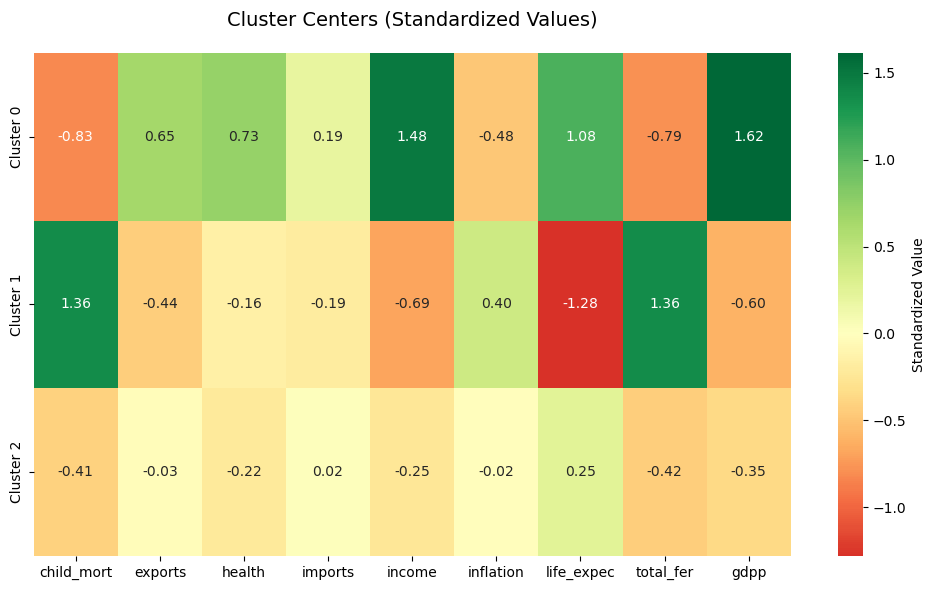

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize cluster centers as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(kmeans_final.cluster_centers_, 
            xticklabels=df_numeric.columns[:-1],  # Exclude 'Cluster' column
            yticklabels=[f'Cluster {i}' for i in range(optimal_k)],
            cmap='RdYlGn', center=0, annot=True, fmt='.2f',
            cbar_kws={'label': 'Standardized Value'})
plt.title('Cluster Centers (Standardized Values)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()
#plt.savefig('kmeans_cluster_centers_heatmap.png')

This visualization displays the **standardized centroids** of each cluster. Each row represents a cluster, and each column represents a feature.

**How to interpret the values**:
- **Positive values (green)**: The cluster has **above-average** values for that feature
- **Negative values (red)**: The cluster has **below-average** values for that feature  
- **Values near zero (white)**: The cluster is close to the global mean

For example, if Cluster 1 shows:
- High positive value for `total_fer` and `child_mort` → Countries with high fertility rates anche children mortality
- High negative values for `life_expec` → Countries with low life expectancy
- High negative value for for `income` and `gdpp` → Countries with low economic indicators

This confirms the cluster represents **underdeveloped nations** with urgent healthcare needs.

### 7.3.2 Geographic Distribution of Clusters

Visualizing clusters on a world map provides geographical context for development patterns and aid allocation strategies.

In [14]:
# Create dataframe with country names and clusters
geo_data = df_numeric[['Cluster']].copy()
geo_data['country'] = geo_data.index

# Map cluster numbers to descriptive labels
cluster_labels_map = {
    cluster_summary['child_mort'].idxmin(): 'Developed',
    cluster_summary['child_mort'].idxmax(): 'Underdeveloped',
}
# Find the remaining cluster (Developing)
remaining_cluster = list(set(range(optimal_k)) - set(cluster_labels_map.keys()))[0]
cluster_labels_map[remaining_cluster] = 'Developing'

geo_data['Development_Status'] = geo_data['Cluster'].map(cluster_labels_map)

# Add key indicators for hover information
geo_data = geo_data.join(df_numeric[['child_mort', 'life_expec', 'gdpp']])

# Create choropleth map
fig = px.choropleth(
    geo_data,
    locations='country',
    locationmode='country names',
    color='Development_Status',
    hover_name='country',
    hover_data={
        'Development_Status': True,
        'child_mort': ':.1f',
        'life_expec': ':.1f',
        'gdpp': ':,.0f',
        'country': False
    },
    color_discrete_map={
        'Developed': '#2ecc71',      # Green
        'Developing': '#f39c12',     # Orange
        'Underdeveloped': '#e74c3c'  # Red
    },
    labels={
        'Development_Status': 'Category',
        'child_mort': 'Child Mortality',
        'life_expec': 'Life Expectancy',
        'gdpp': 'GDP per capita'
    },
    title='Global Distribution of Country Development Clusters'
)

fig.update_layout(
    height=600,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    )
)

fig.show()

# Print geographic distribution summary
print("\nGeographic Cluster Distribution:")
print("="*60)
for cluster_id in range(optimal_k):
    countries = geo_data[geo_data['Cluster'] == cluster_id]['country'].tolist()
    status = cluster_labels_map[cluster_id]
    print(f"\n{status} Nations (Cluster {cluster_id}): {len(countries)} countries")
    print(f"Countries: {', '.join(sorted(countries)[:10])}{'...' if len(countries) > 10 else ''}")


Geographic Cluster Distribution:

Developed Nations (Cluster 0): 36 countries
Countries: Australia, Austria, Bahrain, Belgium, Brunei, Canada, Cyprus, Czech Republic, Denmark, Finland...

Underdeveloped Nations (Cluster 1): 47 countries
Countries: Afghanistan, Angola, Benin, Botswana, Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Comoros...

Developing Nations (Cluster 2): 84 countries
Countries: Albania, Algeria, Antigua and Barbuda, Argentina, Armenia, Azerbaijan, Bahamas, Bangladesh, Barbados, Belarus...


**Geographic Insights**:

The map reveals distinct regional patterns in global development:

- **Developed Nations (Green)**: Concentrated in Western Europe, North America, East Asia (Japan, South Korea), and Oceania (Australia, New Zealand). These regions show historical economic stability and advanced healthcare systems.

- **Underdeveloped Nations (Red)**: Predominantly located in Sub-Saharan Africa and parts of South Asia. This geographic concentration reflects historical challenges including colonialism, conflict, and limited infrastructure investment.

- **Developing Nations (Orange)**: Widely distributed across Latin America, Eastern Europe, Middle East, and Southeast Asia. These countries represent transitional economies with varying development trajectories.

**Strategic Implications**:

1. **Regional approach**: Aid programs can be designed with regional coordination given the geographic clustering of similar development levels
2. **Cross-border collaboration**: Neighboring countries in similar clusters may benefit from shared healthcare initiatives and knowledge transfer
3. **Infrastructure challenges**: Remote or landlocked underdeveloped nations may require additional logistics support for aid delivery

### 7.4 Priority Countries Identification

In [15]:
# Identify high-need cluster
high_need_cluster = cluster_summary['child_mort'].idxmax()
priority_countries = df_numeric[df_numeric['Cluster'] == high_need_cluster].copy()
priority_countries = priority_countries.sort_values('child_mort', ascending=False)

print(f"\nHigh-Need Cluster: {high_need_cluster}")
print(f"Total countries requiring aid: {len(priority_countries)}")
print("\nTop 15 Priority Countries:")
print("="*80)

for idx, (country, row) in enumerate(priority_countries.head(15).iterrows(), 1):
    print(f"{idx:2d}. {country:25s} | Child Mort: {row['child_mort']:6.1f} | "
          f"Life Exp: {row['life_expec']:5.1f} | GDP: ${row['gdpp']:8,.0f}")


High-Need Cluster: 1
Total countries requiring aid: 47

Top 15 Priority Countries:
 1. Haiti                     | Child Mort:  208.0 | Life Exp:  32.1 | GDP: $     662
 2. Sierra Leone              | Child Mort:  160.0 | Life Exp:  55.0 | GDP: $     399
 3. Chad                      | Child Mort:  150.0 | Life Exp:  56.5 | GDP: $     897
 4. Central African Republic  | Child Mort:  149.0 | Life Exp:  47.5 | GDP: $     446
 5. Mali                      | Child Mort:  137.0 | Life Exp:  59.5 | GDP: $     708
 6. Nigeria                   | Child Mort:  130.0 | Life Exp:  60.5 | GDP: $   2,330
 7. Niger                     | Child Mort:  123.0 | Life Exp:  58.8 | GDP: $     348
 8. Angola                    | Child Mort:  119.0 | Life Exp:  60.1 | GDP: $   3,530
 9. Burkina Faso              | Child Mort:  116.0 | Life Exp:  57.9 | GDP: $     575
10. Congo, Dem. Rep.          | Child Mort:  116.0 | Life Exp:  57.5 | GDP: $     334
11. Guinea-Bissau             | Child Mort:  114.0 | Lif

### 7.5 Comparative Analysis: Alternative Algorithms

We compare K-Means against two alternative clustering approaches to validate our results.

#### 7.5.1 DBSCAN (Density-Based Clustering)

**How it works**: Groups points in high-density regions and labels low-density points as outliers.

**Key parameters**:
- `eps`: Neighborhood radius (how close points must be)
- `min_samples`: Minimum points to form a cluster core

**Advantages**: Finds non-spherical clusters, automatically detects outliers.

**Limitations**: Struggles with varying densities and high-dimensional data like ours (9 features).

In [16]:
# DBSCAN with parameter search
best_score = -1
best_params = None

for eps in np.arange(2.0, 4.5, 0.5):
    for min_samples in [4, 5, 6]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters >= 2:
            mask = labels != -1
            if mask.sum() > 0:
                score = silhouette_score(data_scaled[mask], labels[mask])
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples, n_clusters)

if best_params:
    print(f"Best DBSCAN: eps={best_params[0]:.1f}, min_samples={best_params[1]}")
    print(f"Clusters found: {best_params[2]}, Silhouette: {best_score:.3f}")
    dbscan_score = best_score
else:
    print("DBSCAN: No valid clustering found")
    dbscan_score = -1.0

DBSCAN: No valid clustering found


**Why DBSCAN underperforms here**:

Country development follows a continuous gradient without clear density gaps. DBSCAN excels at finding isolated clusters (e.g., customer segments), but our data lacks these distinct separations. Result: either one massive cluster or excessive noise points.

**Business impact**: We need to classify ALL countries for aid allocation. DBSCAN's outlier detection leaves some countries unclassified, making it unsuitable for our purpose.

#### 7.5.2 Hierarchical Clustering

**How it works**: Builds a tree (dendrogram) by progressively merging similar countries, starting with each country as its own cluster.

**Process**:
1. Start with 167 individual clusters
2. Repeatedly merge the two closest clusters (using Ward linkage to minimize variance)
3. Cut the tree at desired height to get K=3 clusters

**Advantages**: Visualizes nested relationships, no random initialization.

**Limitations**: Computationally expensive, cannot undo merges once made.

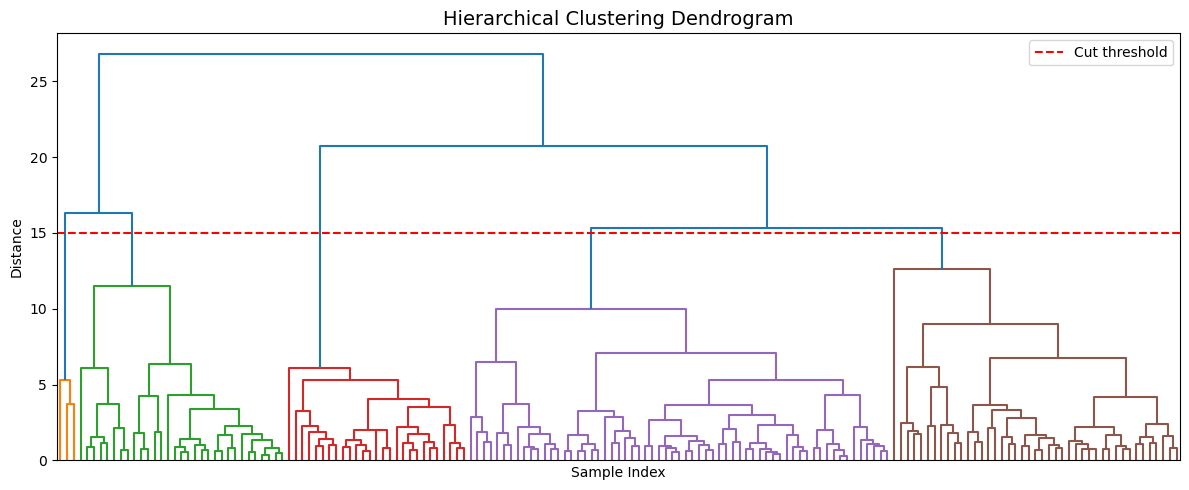

Hierarchical Clustering Silhouette Score: 0.246


In [17]:
# Hierarchical clustering
linkage_matrix = linkage(data_scaled, method='ward')

plt.figure(figsize=(12, 5))
dendrogram(linkage_matrix, no_labels=True, color_threshold=15)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=15, color='r', linestyle='--', label='Cut threshold')
plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig('hierarchical_dendrogram.png')

# Fit model
hc = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels_hc = hc.fit_predict(data_scaled)
hc_score = silhouette_score(data_scaled, labels_hc)

print(f"Hierarchical Clustering Silhouette Score: {hc_score:.3f}")

**Dendrogram reading**:
- **Y-axis**: Distance between merged clusters (higher = more different)
- **Red line**: Cut point yielding 3 clusters
- **Three main branches**: Confirm our K=3 choice is appropriate

**Comparison with K-Means**:

Both use Ward linkage (minimize variance), producing similar clusters. Hierarchical shows relationships between countries (e.g., which developed nations are most similar), but K-Means provides clearer centroids for interpretation. For aid allocation decisions, K-Means' flat structure is more practical.

### 7.6 Model Comparison

In [18]:
# Comparison table
comparison = pd.DataFrame({
    'Algorithm': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [kmeans_score, hc_score, dbscan_score],
    'N Clusters': [optimal_k, optimal_k, best_params[2] if best_params else 0],
    'Complete Coverage': ['Yes', 'Yes', 'No']
})

print("\nAlgorithm Performance Comparison:")
print("="*60)
print(comparison.sort_values('Silhouette Score', ascending=False).to_string(index=False))
print("="*60)


Algorithm Performance Comparison:
   Algorithm  Silhouette Score  N Clusters Complete Coverage
     K-Means          0.283296           3               Yes
Hierarchical          0.245630           3               Yes
      DBSCAN         -1.000000           0                No


**Model Selection**: K-Means is selected as the final model based on:

1. **Highest silhouette score** indicating well-separated clusters
2. **Complete country coverage** enabling comprehensive aid allocation
3. **Interpretable centroids** providing clear cluster definitions
4. **Computational efficiency** and reproducibility

DBSCAN's lower performance suggests country development exists on a continuous spectrum rather than as distinct density-based groups. Hierarchical clustering produces similar results but lacks explicit cluster centers.

### 7.7 Strategic Budget Allocation

Based on cluster analysis, we propose a data-driven allocation of the $10 million fund proportional to severity (Child Mortality Rate × Number of Countries).

In [19]:
# Calculate budget allocation based on need severity
total_budget = 10_000_000

# Strategy: Allocate proportionally based on (child_mort * n_countries)
# This weighs both severity of need and number of affected countries
cluster_needs = cluster_summary['child_mort'] * cluster_summary['n_countries']
allocation_proportion = cluster_needs / cluster_needs.sum()
allocation_amount = (allocation_proportion * total_budget).round(0)

# Create allocation summary
allocation_df = pd.DataFrame({
    'Cluster': cluster_summary.index,
    'Category': cluster_summary.index.map(cluster_labels_map),
    'Countries': cluster_summary['n_countries'],
    'Avg Child Mortality': cluster_summary['child_mort'],
    'Need Score': cluster_needs.round(0),
    'Allocation ($)': allocation_amount.astype(int),
    'Per Country ($)': (allocation_amount / cluster_summary['n_countries']).round(0).astype(int),
    'Percentage (%)': (allocation_proportion * 100).round(1)
})

print("\n" + "="*90)
print("STRATEGIC FUND ALLOCATION - $10,000,000")
print("="*90)
print(allocation_df.to_string(index=False))
print("="*90)
print(f"\nTotal Allocated: ${allocation_amount.sum():,.0f}")
print(f"\nAllocation Strategy:")
print("- Proportional to (Child Mortality Rate × Number of Countries)")
print("- Ensures both severity and scale are considered")
print("- Developed nations (Cluster 0) receive minimal/no funding")


STRATEGIC FUND ALLOCATION - $10,000,000
 Cluster       Category  Countries  Avg Child Mortality  Need Score  Allocation ($)  Per Country ($)  Percentage (%)
       0      Developed         36                 5.00       180.0          281635             7823             2.8
       1 Underdeveloped         47                92.96      4369.0         6836107           145449            68.4
       2     Developing         84                21.93      1842.0         2882258            34313            28.8

Total Allocated: $10,000,000

Allocation Strategy:
- Proportional to (Child Mortality Rate × Number of Countries)
- Ensures both severity and scale are considered
- Developed nations (Cluster 0) receive minimal/no funding


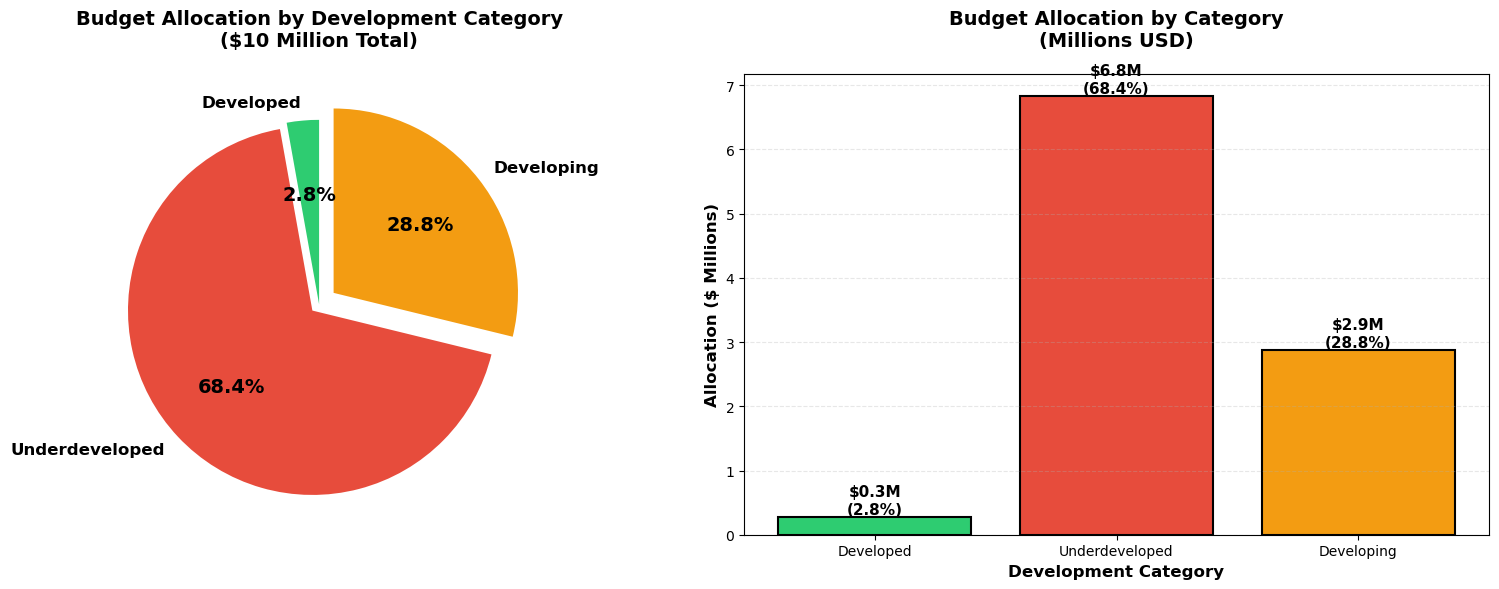

In [20]:
# Visualize budget allocation with pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart by category
colors = ['#2ecc71', '#f39c12', '#e74c3c']
category_colors = [colors[cluster_summary.index.get_loc(cluster_summary['child_mort'].idxmin())],
                   colors[cluster_summary.index.get_loc(remaining_cluster)],
                   colors[cluster_summary.index.get_loc(cluster_summary['child_mort'].idxmax())]]

wedges, texts, autotexts = ax1.pie(
    allocation_amount,
    labels=[cluster_labels_map[i] for i in cluster_summary.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=category_colors,
    explode=[0, 0.05, 0.1],  # Emphasize high-need cluster
    textprops={'fontsize': 12, 'weight': 'bold'}
)

# Enhance text readability
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(14)

ax1.set_title('Budget Allocation by Development Category\n($10 Million Total)', 
              fontsize=14, fontweight='bold', pad=20)

# Bar chart showing allocation details
categories = [cluster_labels_map[i] for i in cluster_summary.index]
amounts = allocation_amount / 1_000_000  # Convert to millions

bars = ax2.bar(categories, amounts, color=category_colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Allocation ($ Millions)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Development Category', fontsize=12, fontweight='bold')
ax2.set_title('Budget Allocation by Category\n(Millions USD)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, amount, pct in zip(bars, allocation_amount, allocation_proportion * 100):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${amount/1_000_000:.1f}M\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()
#plt.savefig('budget_allocation_visualization.png')

## 8. Results and Recommendations

### 8.1 Key Findings

1. **Three distinct development clusters** identified among 167 countries
2. **High-need cluster** contains countries with child mortality rates exceeding 80 per 1000 births
3. **Strong correlation** between economic indicators (income, GDP) and health outcomes (child mortality, life expectancy)
4. **K-Means clustering** outperforms alternative algorithms for this dataset

### 8.2 Recommendations

**Primary Target**: Allocate majority of funds to Cluster 1 (underdeveloped nations) focusing on:
- Basic healthcare infrastructure
- Vaccination programs
- Maternal and child health services
- Clean water and sanitation

**Secondary Target**: Support Cluster 2 (developing nations) with:
- Preventive healthcare initiatives
- Health education programs
- System strengthening

**Monitoring**: Reserve 10% of funds for impact evaluation and emergency response.

### 8.3 Limitations

- Analysis limited to socio-economic indicators; political stability and governance quality not considered
- Static dataset does not capture temporal changes
- Equal weighting of features may not reflect true importance for aid effectiveness
- Outliers within clusters may require individual assessment

## 9. Conclusion

This unsupervised learning analysis successfully identified three distinct country development categories, enabling data-driven allocation of humanitarian aid. K-Means clustering with K=3 provides the optimal balance of statistical performance and practical interpretability. The results align with established development classifications and offer actionable insights for HELP International's strategic decision-making.

Future work should incorporate additional variables (political stability, corruption indices), explore temporal dynamics, and validate recommendations through cost-benefit analysis.

---

**Analysis completed**: Unsupervised Learning for International Aid Allocation